In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
import sys
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# **code for extracting useful lines from raw data**


filename = "thegurus-opendata-renfe-trips.csv"

price_changed = pd.DataFrame([])
count = 0
for df in pd.read_csv(filename, iterator=True, chunksize=10 ** 6):
    count += 1

    df = df.loc[
        (df["meta"] != "{}")
        & (df["origin"] == "MADRID")
        & (df["destination"] == "BARCELONA")
        & (df["vehicle_type"] == "AVE")
    ]

    price_changed = price_changed.append(df)
    print(
        "From {c} million rows, ".format(c=count)
        + str(price_changed.shape[0])
        + " extracted"
    )
    if price_changed.shape[0] > 3 * (10 ** 6):
        break

From 1 million rows, 0 extracted
From 2 million rows, 0 extracted
From 3 million rows, 0 extracted
From 4 million rows, 0 extracted
From 5 million rows, 0 extracted
From 6 million rows, 0 extracted
From 7 million rows, 0 extracted
From 8 million rows, 0 extracted
From 9 million rows, 0 extracted
From 10 million rows, 0 extracted
From 11 million rows, 0 extracted
From 12 million rows, 0 extracted
From 13 million rows, 0 extracted
From 14 million rows, 0 extracted
From 15 million rows, 0 extracted
From 16 million rows, 35805 extracted
From 17 million rows, 185790 extracted
From 18 million rows, 268558 extracted
From 19 million rows, 347055 extracted
From 20 million rows, 403159 extracted
From 21 million rows, 433004 extracted
From 22 million rows, 478335 extracted
From 23 million rows, 524175 extracted
From 24 million rows, 566645 extracted
From 25 million rows, 609116 extracted
From 26 million rows, 653375 extracted
From 27 million rows, 697679 extracted
From 28 million rows, 703435 ext

In [8]:
price_changed.to_pickle("data/MAD_BAR_all.pkl")

In [69]:
#read clean dataset
df = pd.read_pickle("clean.pkl")

In [70]:
# investigate only AVE trains
df = df.loc[df["vehicle_type"]=="AVE"].reset_index(drop=True)

# generate train_id
df["train_id"] = df[["origin", "destination", "departure","arrival"]].sum(axis=1)

In [71]:
df["route"] = df["origin"] + " to " + df["destination"]

In [72]:
cut = 10000
routes = df["route"].value_counts()

routes["other"] = routes[routes < cut].sum()

routes = routes[routes > cut]

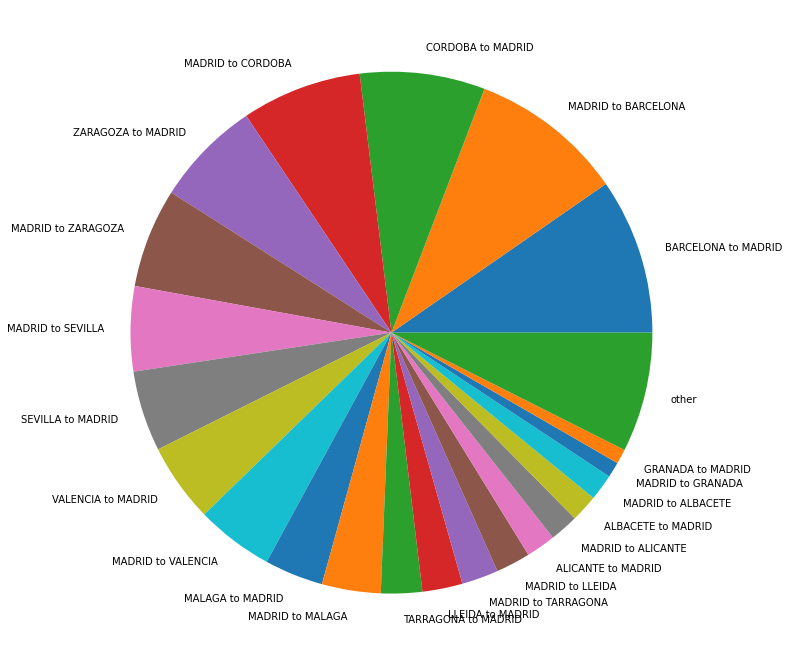

In [73]:
pie, ax = plt.subplots(figsize=[12, 12])
plt.pie(x=routes, labels=routes.keys())
plt.show()


In [115]:
# get Madrid-Barcelona trains departing 8:30

trains = (
    df.groupby("train_id")
    .first()
    .reset_index()
    .query("(origin == 'MADRID')&(destination=='BARCELONA')")
    .reset_index(drop=True)
)

morning_train = pd.DataFrame(columns=trains.columns)

for i in range(trains.shape[0]):
    if (
        datetime.datetime.strptime(trains.loc[i, "departure"], "%Y-%m-%d %H:%M:%S").hour
        == 8
    ) & (
        datetime.datetime.strptime(
            trains.loc[i, "departure"], "%Y-%m-%d %H:%M:%S"
        ).minute
        == 30
    ):
        morning_train = pd.concat(
            [morning_train, pd.DataFrame(trains.loc[i]).T], axis=0
        ).reset_index(drop=True)

In [116]:
# ezek  a vonatok mennek Madridból Barceloxqnába minden reggel 8:30tól:
morning_train["train_id"]

0      MADRIDBARCELONA2020-01-31 08:30:002020-01-31 1...
1      MADRIDBARCELONA2020-02-01 08:30:002020-02-01 1...
2      MADRIDBARCELONA2020-02-02 08:30:002020-02-02 1...
3      MADRIDBARCELONA2020-02-03 08:30:002020-02-03 1...
4      MADRIDBARCELONA2020-02-04 08:30:002020-02-04 1...
                             ...                        
129    MADRIDBARCELONA2020-06-08 08:30:002020-06-08 1...
130    MADRIDBARCELONA2020-06-09 08:30:002020-06-09 1...
131    MADRIDBARCELONA2020-06-10 08:30:002020-06-10 1...
132    MADRIDBARCELONA2020-06-11 08:30:002020-06-11 1...
133    MADRIDBARCELONA2020-06-12 08:30:002020-06-12 1...
Name: train_id, Length: 134, dtype: object

In [117]:
#kiválasztok 7-et egy márciusi hétről
train_id = []
for i in range(0, 7):
    train_id.append(morning_train.loc[35 + i, "train_id"])

In [118]:
train_id

['MADRIDBARCELONA2020-03-06 08:30:002020-03-06 11:15:00',
 'MADRIDBARCELONA2020-03-07 08:30:002020-03-07 11:15:00',
 'MADRIDBARCELONA2020-03-08 08:30:002020-03-08 11:15:00',
 'MADRIDBARCELONA2020-03-09 08:30:002020-03-09 11:15:00',
 'MADRIDBARCELONA2020-03-10 08:30:002020-03-10 11:15:00',
 'MADRIDBARCELONA2020-03-11 08:30:002020-03-11 11:15:00',
 'MADRIDBARCELONA2020-03-12 08:30:002020-03-12 11:15:00']

In [119]:
# van belőlük sok elég price-seat adat
for id in train_id:
    train = df.loc[df["train_id"] == id].reset_index(drop=True)
    print(train.shape)

(82, 16)
(78, 16)
(98, 16)
(88, 16)
(73, 16)
(72, 16)
(83, 16)


In [120]:
#most kiválaszotom az összes adatom erről a 7 vonatról
trains = df.loc[df["train_id"].isin(train_id)].reset_index(drop=True).set_index("train_id")

In [121]:
# a price-seat adatok a meta változóban vannak, 
# ami egy mindig más struktúrájú dictionary,
# elég trükkös volt kinyerni, arra írtam ezt a fgv-t

def extract_meta(train):
    prices_seats = pd.DataFrame()
    for i in range(train.shape[0]):
        dic_in = json.loads(train.meta[i])
        # extract values from tree dictionary
        while type(list(dic_in.values())[0]) != float:
            res = {key: list(value) for key, value in dic_in.items()}
            dic_out = {}
            for key in res.keys():
                for value in res[key]:
                    dic_out[key + "_" + value] = dic_in[key][value]
            dic_in = dic_out

        # check for seats, if no seat its the price
        for key in list(dic_in.keys()):
            if "seats" not in key:
                if "price" not in key:
                    dic_in[key + "_price"] = dic_in[key]
                    dic_in.pop(key)

        prices_seats = pd.concat(
            [prices_seats, pd.DataFrame.from_dict(dic_in, orient="index").T]
        ).reset_index(drop=True)
    return prices_seats

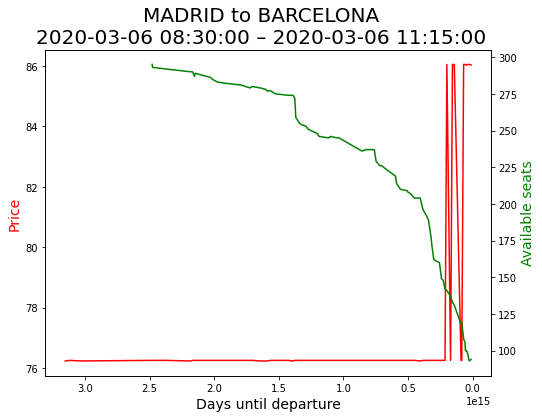

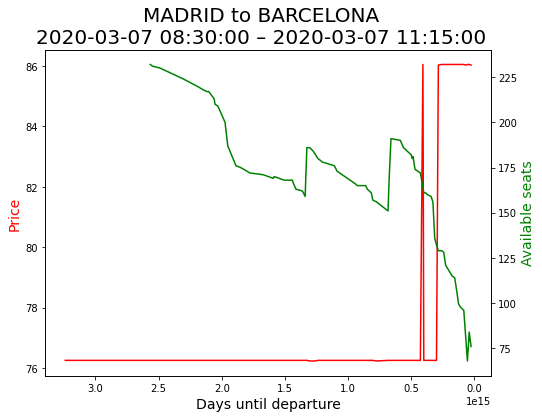

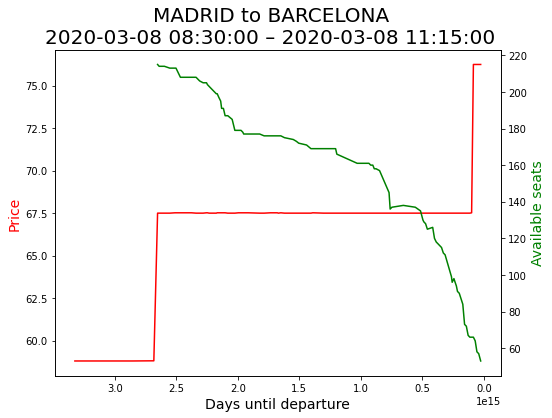

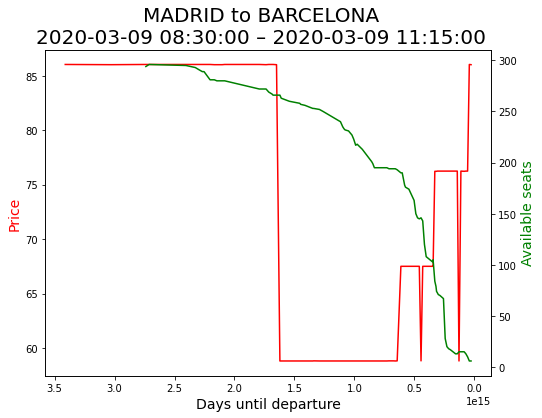

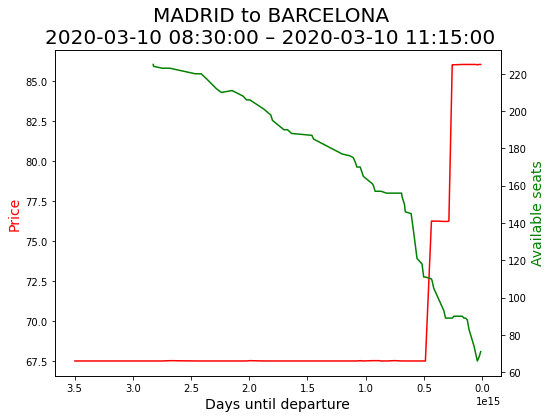

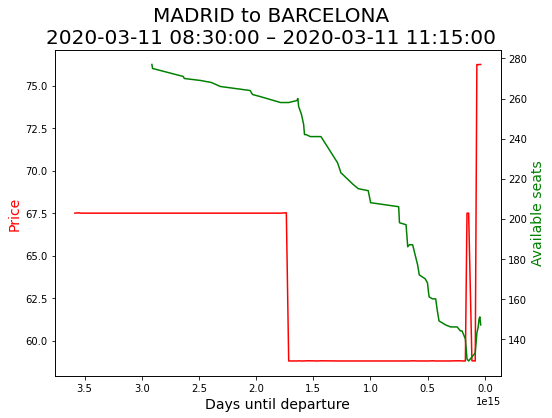

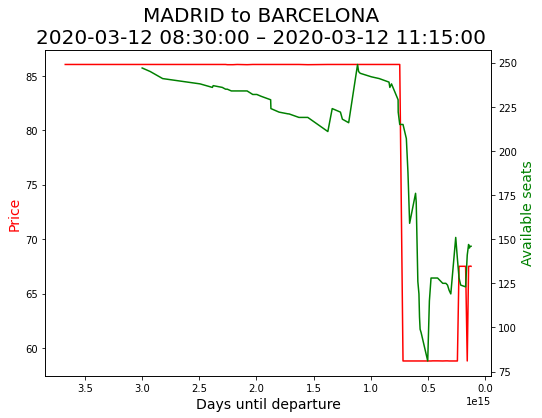

In [122]:
for i in range(len(train_id)):

    train = pd.concat(
        [
            trains.loc[train_id[i], :].reset_index(),
            extract_meta(trains.loc[train_id[i], :]),
        ],
        axis=1,
    )

    train["timedelta_till_dep"] = [
        (
            datetime.datetime.strptime(train.loc[i, "departure"], "%Y-%m-%d %H:%M:%S")
            - datetime.datetime.strptime(
                train.loc[i, "insert_date"], "%Y-%m-%d %H:%M:%S"
            )
        )
        for i in range(train.shape[0])
    ]
    train["days_till_dep"] = [
        (
            datetime.datetime.strptime(train.loc[i, "departure"], "%Y-%m-%d %H:%M:%S")
            - datetime.datetime.strptime(
                train.loc[i, "insert_date"], "%Y-%m-%d %H:%M:%S"
            )
        ).days
        for i in range(train.shape[0])
    ]

    fig, ax = plt.subplots(figsize=(8, 6))
    # make a plot
    ax.plot("timedelta_till_dep", "Turista_Promo_price", data=train, color="red")
    # ax.plot("timedelta_till_dep", "Turista_promo+_price", data=train, color="purple")
    # set x-axis label
    ax.set_xlabel("Days until departure", fontsize=14)
    # set y-axis label
    ax.set_ylabel("Price", color="red", fontsize=14)
    # ax.legend(
    #    ("Promo","Promo +"),
    # Ű    loc="center left",
    # Ű    prop={"size": 13},
    # Ű)
    
    plt.suptitle(
        (
            train["origin"]
            + " to "
            + train["destination"]
            + "\n"
            + train["departure"]
            + " – "
            + train["arrival"]
        )[0],
        fontsize=20,
    )

    # twin object for two different y-axis on the sample plot
    ax2 = ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot("timedelta_till_dep", "Turista_Promo_seats", data=train, color="green")
    ax2.set_ylabel("Available seats", color="green", fontsize=14)

    plt.gca().invert_xaxis()

    #plt.savefig("madrid_barc_{i}.jpg".format(i=i))
    plt.show()